In [1]:
import cv2
import numpy as np
import torch
import onnxruntime as ort
import sys
from ultralytics.yolo.utils import ROOT, yaml_load
from ultralytics.yolo.utils.checks import check_requirements, check_yaml
import time

class Yolov8:
    def __init__(self, onnx_model, input_image, confidence_thres, iou_thres):
        """
        Initializes an instance of the Yolov8 class.

        Args:
            onnx_model: Path to the ONNX model.
            input_image: Path to the input image.
            confidence_thres: Confidence threshold for filtering detections.
            iou_thres: IoU (Intersection over Union) threshold for non-maximum suppression.
        """
        self.onnx_model = onnx_model
        self.input_image = input_image
        self.confidence_thres = confidence_thres
        self.iou_thres = iou_thres

        # Load the class names from the COCO dataset
        self.classes = yaml_load(check_yaml('coco128.yaml'))['names']

        # Generate a color palette for the classes
        self.color_palette = np.random.uniform(0, 255, size=(len(self.classes), 3))

    def draw_detections(self, img, box, score, class_id):
        """
        Draws bounding boxes and labels on the input image based on the detected objects.

        Args:
            img: The input image to draw detections on.
            box: Detected bounding box.
            score: Corresponding detection score.
            class_id: Class ID for the detected object.

        Returns:
            None
        """

        # Extract the coordinates of the bounding box
        x1, y1, w, h = box

        # Retrieve the color for the class ID
        color = self.color_palette[class_id]

        # Draw the bounding box on the image
        cv2.rectangle(img, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)

        # Create the label text with class name and score
        label = f'{self.classes[class_id]}: {score:.2f}'

        # Calculate the dimensions of the label text
        (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

        # Calculate the position of the label text
        label_x = x1
        label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10

        # Draw a filled rectangle as the background for the label text
        cv2.rectangle(img, (label_x, label_y - label_height), (label_x + label_width, label_y + label_height), color,
                      cv2.FILLED)

        # Draw the label text on the image
        cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    def preprocess(self):
        """
        Preprocesses the input image before performing inference.

        Returns:
            image_data: Preprocessed image data ready for inference.
        """
        # Read the input image using OpenCV
        self.img = cv2.imread(self.input_image)

        # Get the height and width of the input image
        self.img_height, self.img_width = self.img.shape[:2]

        # Convert the image color space from BGR to RGB
        img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)

        # Resize the image to match the input shape
        img = cv2.resize(img, (self.input_width, self.input_height))

        # Normalize the image data by dividing it by 255.0
        image_data = np.array(img) / 255.0

        # Transpose the image to have the channel dimension as the first dimension
        image_data = np.transpose(image_data, (2, 0, 1))  # Channel first

        # Expand the dimensions of the image data to match the expected input shape
        image_data = np.expand_dims(image_data, axis=0).astype(np.float32)

        # Return the preprocessed image data
        return image_data

    def postprocess(self, input_image, output):
        """
        Performs post-processing on the model's output to extract bounding boxes, scores, and class IDs.

        Args:
            input_image (numpy.ndarray): The input image.
            output (numpy.ndarray): The output of the model.

        Returns:
            numpy.ndarray: The input image with detections drawn on it.
        """

        # Transpose and squeeze the output to match the expected shape
        outputs = np.transpose(np.squeeze(output[0]))

        # Get the number of rows in the outputs array
        rows = outputs.shape[0]

        # Lists to store the bounding boxes, scores, and class IDs of the detections
        boxes = []
        scores = []
        class_ids = []

        # Calculate the scaling factors for the bounding box coordinates
        x_factor = self.img_width / self.input_width
        y_factor = self.img_height / self.input_height

        # Iterate over each row in the outputs array
        for i in range(rows):
            # Extract the class scores from the current row
            classes_scores = outputs[i][4:]

            # Find the maximum score among the class scores
            max_score = np.amax(classes_scores)

            # If the maximum score is above the confidence threshold
            if max_score >= self.confidence_thres:
                # Get the class ID with the highest score
                class_id = np.argmax(classes_scores)

                # Extract the bounding box coordinates from the current row
                x, y, w, h = outputs[i][0], outputs[i][1], outputs[i][2], outputs[i][3]

                # Calculate the scaled coordinates of the bounding box
                left = int((x - w / 2) * x_factor)
                top = int((y - h / 2) * y_factor)
                width = int(w * x_factor)
                height = int(h * y_factor)

                # Add the class ID, score, and box coordinates to the respective lists
                class_ids.append(class_id)
                scores.append(max_score)
                boxes.append([left, top, width, height])

        # Apply non-maximum suppression to filter out overlapping bounding boxes
        indices = cv2.dnn.NMSBoxes(boxes, scores, self.confidence_thres, self.iou_thres)

        # Iterate over the selected indices after non-maximum suppression
        for i in indices:
            # Get the box, score, and class ID corresponding to the index
            box = boxes[i]
            score = scores[i]
            class_id = class_ids[i]

            # Draw the detection on the input image
            self.draw_detections(input_image, box, score, class_id)

        # Return the modified input image
        return boxes, scores, class_ids

    def main(self):
        """
        Performs inference using an ONNX model and returns the output image with drawn detections.

        Returns:
            output_img: The output image with drawn detections.
        """
        # Create an inference session using the ONNX model and specify execution providers
        session = ort.InferenceSession(self.onnx_model, providers=['CUDAExecutionProvider'])

        # Get the model inputs
        model_inputs = session.get_inputs()

        # Store the shape of the input for later use
        input_shape = model_inputs[0].shape
        self.input_width = input_shape[3]
        self.input_height = input_shape[2]

        # Preprocess the image data
        st = time.time()
        img_data = self.preprocess()
        ed = time.time()
        print(f"preprocess time: {(ed - st) * 1000:.3f}ms")

        # Run inference using the preprocessed image data
        st = time.time()
        outputs = session.run(None, {model_inputs[0].name: img_data})
        ed = time.time()
        print(f"inference time : {(ed - st) * 1000:.3f}ms")

        # Perform post-processing on the outputs to obtain output image.
        st = time.time()
        boxes, scores, class_ids = self.postprocess(self.img, outputs)
        ed = time.time()
        print(f"postprocess time : {(ed - st) * 1000:.3f}ms")

        # Return the resulting output image
        return boxes, scores, class_ids

In [7]:
model = "/opt/ml/final_project/pmt/train/weights/best.onnx"
img = "/opt/ml/final_project/data/valid/images/6_jpg.rf.8e64486f4a8cada05dbda16372706f02.jpg"
detection = Yolov8(model, img, confidence_thres=0.5, iou_thres=0.5)

In [8]:
import time
st = time.time()
boxes, scores, class_ids = detection.main()
ed = time.time()

preprocess time: 24.478ms
inference time : 384.141ms
postprocess time : 32.133ms


In [21]:
(ed -st)

0.5306568145751953

In [11]:
boxes, scores, class_ids

([[0, 648, 1901, 223],
  [0, 648, 1904, 221],
  [-7, 648, 1914, 222],
  [-9, 647, 1929, 223],
  [-8, 647, 1930, 221],
  [-1, 646, 1924, 223],
  [0, 646, 1916, 224],
  [11, 647, 1911, 224],
  [22, 648, 1900, 223],
  [24, 648, 1892, 222]],
 [0.8539933,
  0.83058804,
  0.8495528,
  0.8813004,
  0.9130346,
  0.92137206,
  0.8970876,
  0.8686161,
  0.8329072,
  0.82463914],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

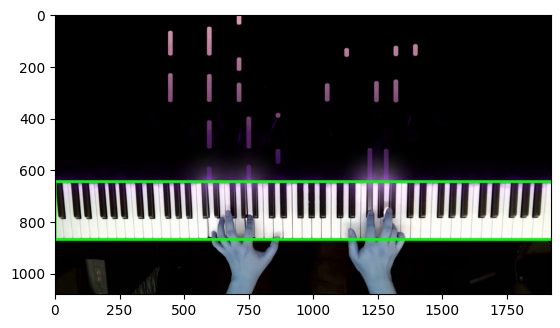

In [16]:
import matplotlib.pyplot as plt
image = cv2.imread(img)
cv2.rectangle(image, (0, 646), (1924, 646+ 223), (0, 255, 0), 10)
plt.imshow(image)
